<a href="https://colab.research.google.com/github/jie786389209/DL-demo/blob/master/Generating_Handwritten_Digits_with_DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf 
tf.enable_eager_execution()

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import time
from IPython import display


In [2]:
(train_images, train_labels),( _, _ ) = tf.keras.datasets.mnist.load_data()


11493376/11490434 [==============================] - 0s 0us/step


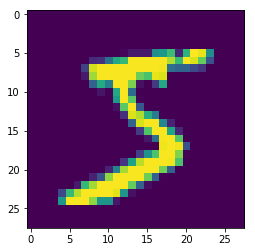

In [3]:
train_images.shape
plt.imshow(train_images[0])

In [0]:
train_images = train_images.reshape(train_images.shape[0], 28,28,1).astype('float32')
train_images = (train_images - 127.5) / 127.5

In [5]:
print(train_images.shape)


(60000, 28, 28, 1)


In [0]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset

<DatasetV1Adapter shapes: (?, 28, 28, 1), types: tf.float32>

生成器负责创建足够欺骗判决器的图像，生成器的网络结构包括上采样层，我们使用一个全连接层和上采样两次来使目标图像大小达到28*28*1。我们增加宽度和高度，流过网络时减少深度。我们使用对每一层使用leaky relu激活函数，除了最后一层我们使用tanh激活函数。

In [0]:
def make_generator_model():
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.LeakyReLU())
  
  model.add(tf.keras.layers.Reshape((7,7,256)))
  assert model.output_shape == (None, 7,7,256)
  
  model.add(tf.keras.layers.Conv2DTranspose(128,(5,5), strides=(1,1), padding='same', use_bias=False))
  assert model.output_shape == (None, 7,7,128)
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.LeakyReLU())
  
  model.add(tf.keras.layers.Conv2DTranspose(64,(5,5), strides=(2,2), padding='same', use_bias=False))
  assert model.output_shape == (None, 14,14,64)
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.LeakyReLU())
  
  model.add(tf.keras.layers.Conv2DTranspose(1,(5,5), strides=(2,2), padding='same', use_bias=False, activation='tanh'))
  assert model.output_shape == (None, 28,28,1)
  
  return model
  
  

In [0]:
def make_discriminator_model():
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Conv2D(64,(5,5), strides=(2,2), padding='same'))
  model.add(tf.keras.layers.LeakyReLU())
  model.add(tf.keras.layers.Dropout(0.3))
  
  model.add(tf.keras.layers.Conv2D(128,(5,5), strides=(2,2), padding='same'))
  model.add(tf.keras.layers.LeakyReLU())
  model.add(tf.keras.layers.Dropout(0.3))
  
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(1))
  
  return model

In [10]:
generator = make_generator_model()
discriminator = make_discriminator_model()


Instructions for updating:
Colocations handled automatically by placer.


生成器的损失函数：

生成图像和全1（生成器尝试生成类似真图的图）的sigmoid交叉熵函数。


In [0]:
def generator_loss(generated_output):
  return tf.losses.sigmoid_cross_entropy(tf.ones_like(generated_output), generated_output)

判别器的损失函数：

计算真实的损失=真实图像和全1（因为是真图）的sigmoid交叉熵函数。

计算生成的损失=真是图像和全0（因为是假图）的sigmoid交叉熵函数。

计算上面两者的总和。

In [0]:
def discriminator_loss(real_output, generated_output):
  real_loss = tf.losses.sigmoid_cross_entropy(multi_class_labels=tf.ones_like(real_output), logits=real_output)
  generated_loss = tf.losses.sigmoid_cross_entropy(multi_class_labels=tf.zeros_like(generated_output), logits=generated_output)
  total_loss = real_loss + generated_loss
  
  return total_loss

In [0]:
generator_optimizer = tf.train.AdamOptimizer(1e-4)
discriminator_optimizer = tf.train.AdamOptimizer(1e-4)


In [14]:
print(os.getcwd())
#os.mkdir("model_save")
#os.chdir("model_save")
#print(os.getcwd())

/content


In [15]:
checkpoint_path = os.getcwd()
checkpoint_path = checkpoint_path + "-{epoch:02d}"
print(checkpoint_path)

/content-{epoch:02d}


In [0]:
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                discriminator_optimizer=discriminator_optimizer,
                                generator=generator,
                                discriminator=discriminator)

In [0]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16
random_vector_for_generation = tf.random_normal([num_examples_to_generate,
                                                noise_dim])

In [0]:
def train_step(images):
  noise = tf.random_normal([BATCH_SIZE, noise_dim])
  
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)
    
    real_output = discriminator(images, training=True)
    generated_output = discriminator(generated_images, training=True)
    
    gen_loss = generator_loss(generated_output)
    disc_loss = discriminator_loss(real_output, generated_output)
  
  gradients_of_generator = gen_tape.gradient(gen_loss, generator.variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.variables)
  
  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.variables))

In [19]:
train_step = tf.contrib.eager.defun(train_step)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



通过tf.contrib.eager.defun函数可以创建图函数，使速度得到提升

In [0]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()
    
    for images in dataset:
      train_step(images)
    
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             random_vector_for_generation)
    
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix=checkpoint_path)
     
    print('Time taken for epoch {} is {} sec'.format(epoch + 1,
                                                    time.time() - start))
    
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                          epochs,
                          random_vector_for_generation)

In [0]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)
  fig = plt.figure(figsize=(4,4))
  for i in range(predictions.shape[0]):
    plt.subplot(4,4,i+1)
    plt.imshow(predictions[i, :, :, 0]*127.5 +127.5, cmap='gray')
    plt.axis('off')
    
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

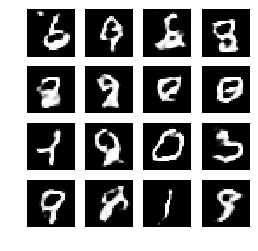

CPU times: user 2min 13s, sys: 41 s, total: 2min 54s
Wall time: 9min 49s


In [22]:
%%time
train(train_dataset, EPOCHS)

In [188]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_path))

In [0]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

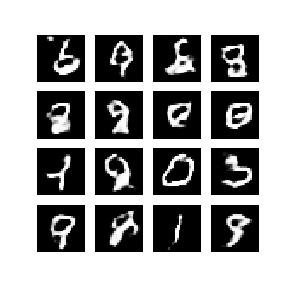

In [24]:
display_image(EPOCHS)

In [27]:
with imageio.get_writer('dcgan.gif', mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

os.system('cp dcgan.gif dcgan.gif.png')


0

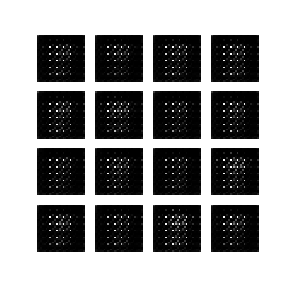

In [28]:
display.Image(filename="dcgan.gif.png")